In [1]:
print("ok")

ok


In [2]:
from langchain_openai import ChatOpenAI

In [3]:
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [6]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [7]:
openai_model=ChatOpenAI(model="gpt-4o")

In [8]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'stop', 'logprobs': None}, id='run-89dec87b-7177-4fd6-bc1a-14a5790ee9d9-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [9]:
openai_model.invoke("hi").content

'Hello! How can I assist you today?'

In [10]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [15]:
state={}

In [16]:
state["messages"]=[]

In [17]:
state

{'messages': []}

In [18]:
state["messages"].append("hi")

In [19]:
state

{'messages': ['hi']}

In [20]:
state["messages"].append("how are you?")

In [21]:
state

{'messages': ['hi', 'how are you?']}

In [22]:
state["messages"].append("what going on?")

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [23]:
state

{'messages': ['hi', 'how are you?', 'what going on?']}

In [24]:
state["messages"][0]

'hi'

In [25]:
state["messages"][-1]

'what going on?'

In [ ]:
## this state is a dict which containing the message as list and inside the list there could be n numbvers of messages

## this state will be flowing across all the nodes(function) in langgraph

In [26]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=openai_model.invoke(question)
    return {"messages":[response]}

In [27]:
workflow=StateGraph(MessagesState)

In [28]:
workflow.add_node("chatbot",call_model)

In [30]:
workflow.add_edge(START,"chatbot")

In [32]:
workflow.add_edge("chatbot",END)

In [34]:
app=workflow.compile()

In [39]:
from IPython.display import Image,display

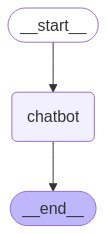

In [36]:
display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
input={"messages":["hi my name is sunny"]}

In [39]:
response=app.invoke(input)

In [40]:
response["messages"][-1].content

'Hi Sunny! How can I assist you today?'

In [41]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content='Hello, Sunny! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 12, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'stop', 'logprobs': None}, id='run-903df924-4611-4362-a679-75ec97dc96e3-0', usage_metadata={'input_tokens': 12, 'output_tokens': 12, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}




In [11]:
@tool
def search(query:str):
    """this is a tool for weather checking"""
    if "india" in query.lower() or "delhi" in query.lower():
        return "the weather is hotty with some foggy"
    return "weather is cloudy with some darkness"

In [12]:
search.invoke("what is a weather in japan?")

'weather is cloudy with some darkness'

In [13]:
search.invoke("what is a weather in delhi?")

'the weather is hotty with some foggy'

In [14]:
tools=[search]

In [15]:
llm_with_tool=openai_model.bind_tools(tools)

In [16]:
response=llm_with_tool.invoke("hi")

In [17]:
response.content

'Hello! How can I assist you today?'

In [18]:
response.tool_calls

[]

In [19]:
result=llm_with_tool.invoke("what is a weather in europ?")

In [20]:
result.content

''

In [21]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current weather in Europe'},
  'id': 'call_tol5hOy9LHURFgg9ZAxusqT9',
  'type': 'tool_call'}]

In [23]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [24]:
input={'messages': ['hi my name is sunny']}

In [25]:
response=call_model(input)

In [26]:
message=response["messages"]

In [27]:
last_message=message[-1]

In [28]:
last_message.content

'Hello Sunny! How can I assist you today?'

In [29]:
last_message.tool_calls

[]

In [30]:
input={'messages': ['what is a weather in mumbai?']}

In [42]:
def router_function(state: MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [43]:
tools

[StructuredTool(name='search', description='this is a tool for weather checking', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001A1C4A789D0>)]

In [44]:
tool_node=ToolNode(tools)

In [45]:
workflow=StateGraph(MessagesState)

In [46]:
workflow.add_node("assistant",call_model)
workflow.add_node("myweathertool",tool_node)

In [47]:
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "myweathertool", END: END})

app = workflow.compile()

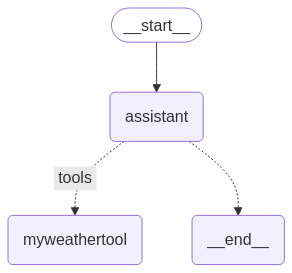

In [48]:
display(Image(app.get_graph().draw_mermaid_png()))

In [50]:
app.invoke({"messages": ["how are you?"]})

{'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}, id='35304953-def9-411a-af33-c13da0c59f4c'),
  AIMessage(content="I'm just a computer program, but I'm here and ready to assist you with any questions or tasks you have! How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 48, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'stop', 'logprobs': None}, id='run-3157f5ac-6c9a-4994-8049-5df4c46f80bc-0', usage_metadata={'input_tokens': 48, 'output_tokens': 31, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [49]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='ab97e960-4f75-4bc2-b33d-2e71af5e9636'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yGUyksdfre0oMUxMjgvXqlDE', 'function': {'arguments': '{"query":"current weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 52, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-285abba1-b433-40a6-a6c4-c7cab0b01878-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in Delhi'}, 'id': 'call_yGUyksdfre0oMUxMjgvXqlDE', 'type': 'tool_call'}], usa